# Data Analysis

The aim of this project is to show Digital Assets Data customers data they could use. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset into memory
block_data = pd.read_csv('blockchain_data.csv')
market_data = pd.read_csv('market_data.csv')

In [3]:
# Rename asset_id column
market_data = market_data.rename(columns={'base_asset_id':'asset_id'})

# Merge block_data into market_data
new_data = market_data.merge(block_data,how='left',on=['asset_id','epoch_ts'])

In [4]:
# Create datetime index from 'epoch_ts' column and sort ascending
new_data.index = [pd.to_datetime(x[:10]) for x in new_data['epoch_ts']]
new_data = new_data.sort_index()

# Drop string columns
new_data = new_data.drop(['quote_asset_id','epoch_ts'],axis=1)

In [5]:
# Create Return Labels (one day forward returns)
new_data.loc[:,'return_1d'] = new_data.groupby(by='asset_id')['price_close'].transform(lambda x: x.pct_change().shift(-1))

In [6]:
new_data[new_data['asset_id']=='NEO_NEO_NEO'].head(3)

,asset_id,price_open,price_high,price_low,price_close,price_mean_a,price_std,price_vwap_a,price_vwap_h,cnt_total,...,fee_low,fee_mean_q,fee_mean_a,fee_mean_g,fee_mean_h,fee_std,block_reward_sum,supply_total,blockchain_size,return_1d
2018-01-01,NEO_NEO_NEO,72.294634,80.430000,69.595587,76.614987,73.890245,1.681884,73.805626,73.766234,113200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115129
2018-01-02,NEO_NEO_NEO,80.206977,99.607000,71.529375,85.435576,87.474352,4.553346,87.142326,86.877034,274745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187978
2018-01-03,NEO_NEO_NEO,89.276242,107.045769,81.493619,101.495606,93.045310,4.427362,93.020048,92.801143,227847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.061505


In [7]:
# Change data to rate of change
for i in new_data:
    if (i != 'asset_id') and (i != 'return_1d'):
        new_data.loc[:,i] = new_data.groupby(by='asset_id')[i].transform(lambda x: x.pct_change())

Below is a collection of charts that show how the one day return of each asset is correlated with data provided by Digital Asset Data. This information is useful because it can help lead to ideas for trading rules and risk management. For example, the correlation between Ripple's price standard deviation and its one day returns is high. Meaning that Ripple's price generally moves higher when there is volatility in its price. Etherium exhibits different characteristics. When its price volatility is high, returns tend to be lower. Information like this can be used in research to make trading rules such as go long Ripple and Short Etherium when both coins have high price volatility.   

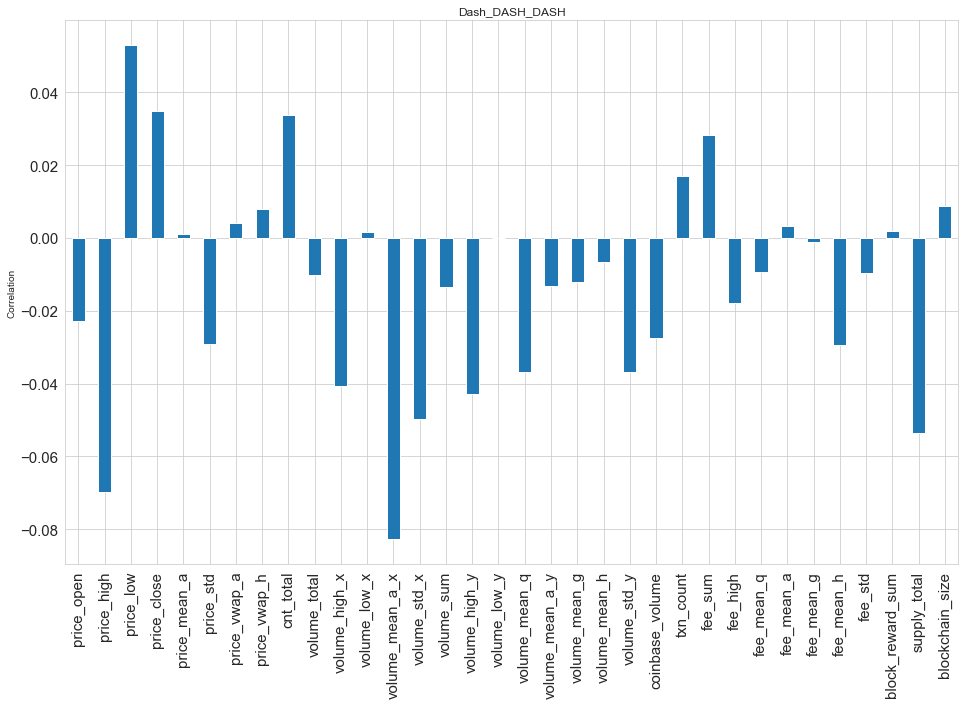

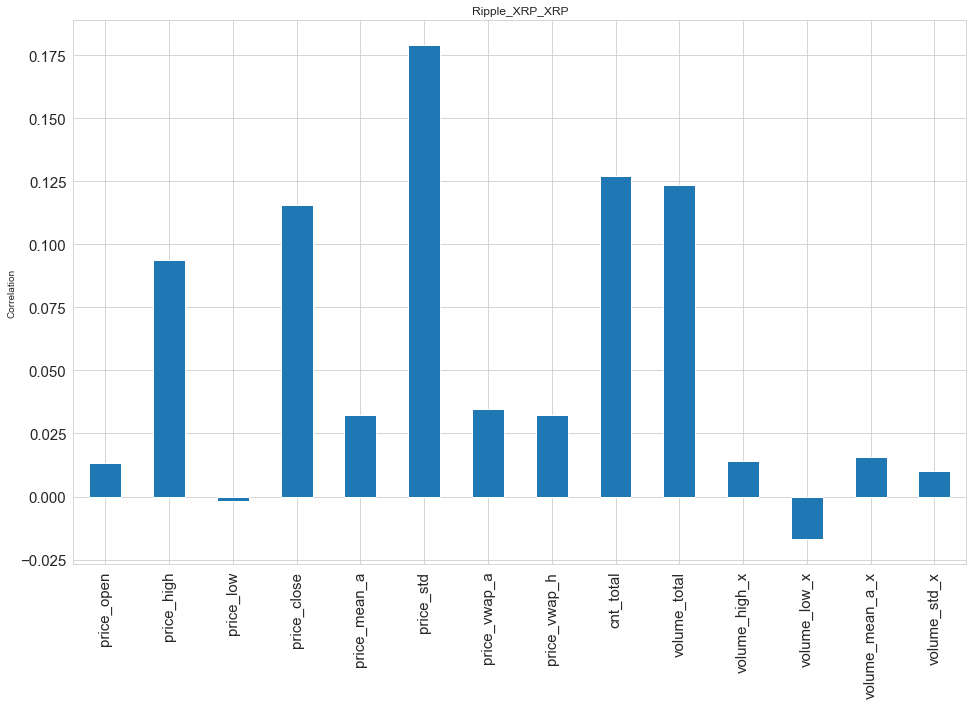

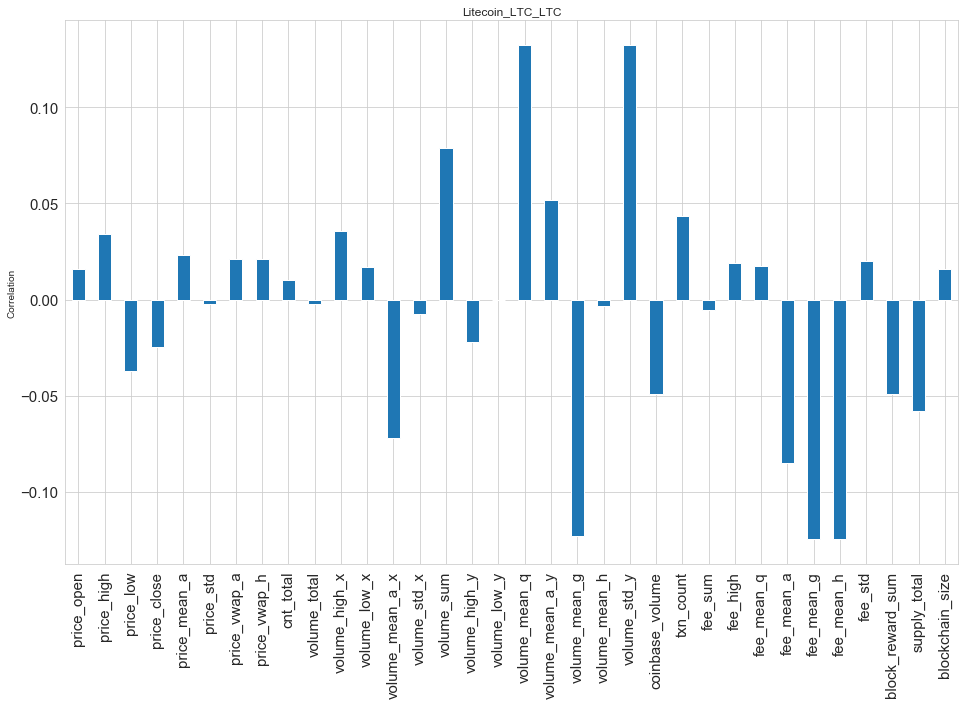

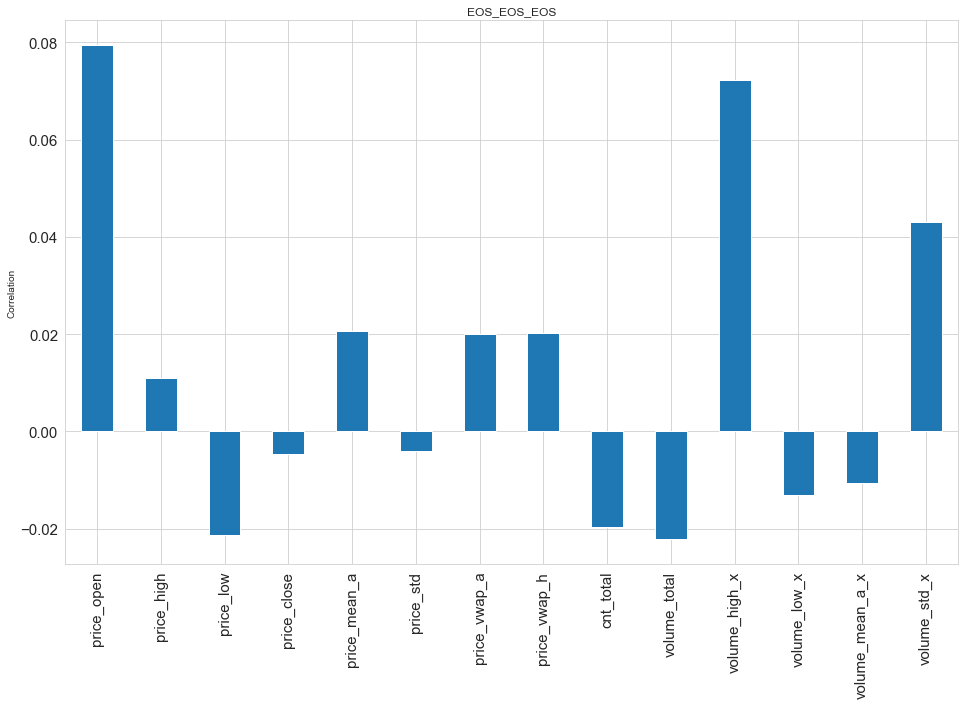

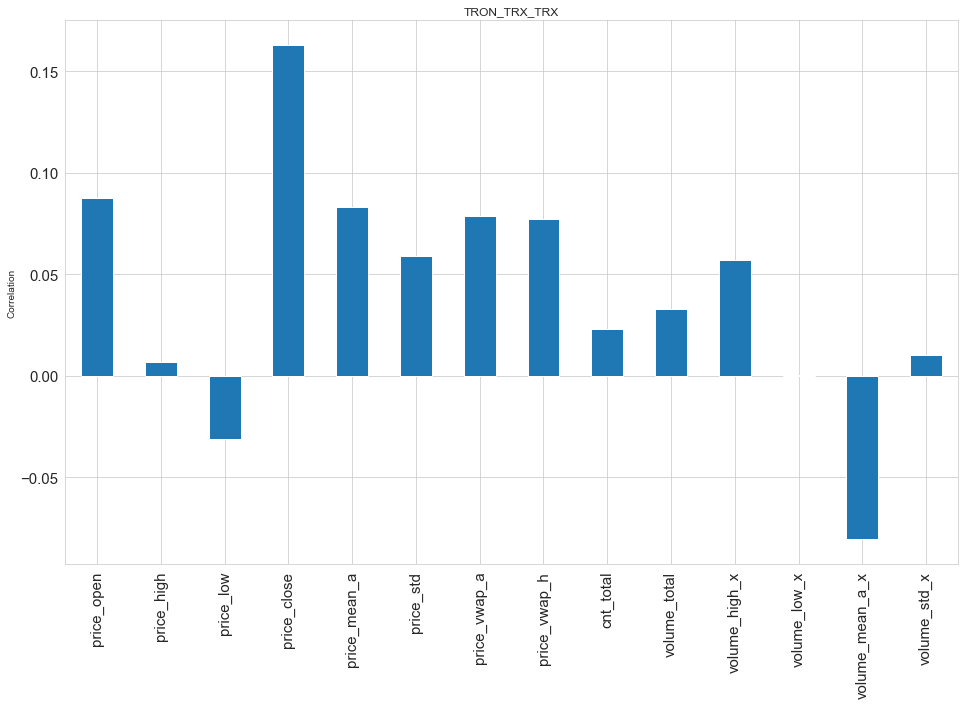

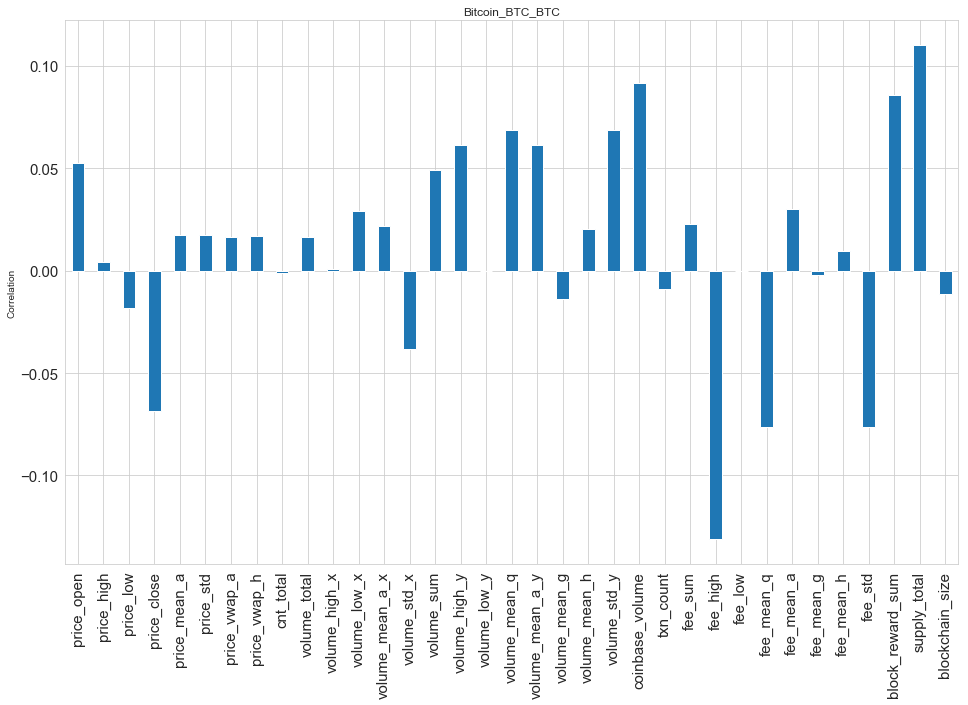

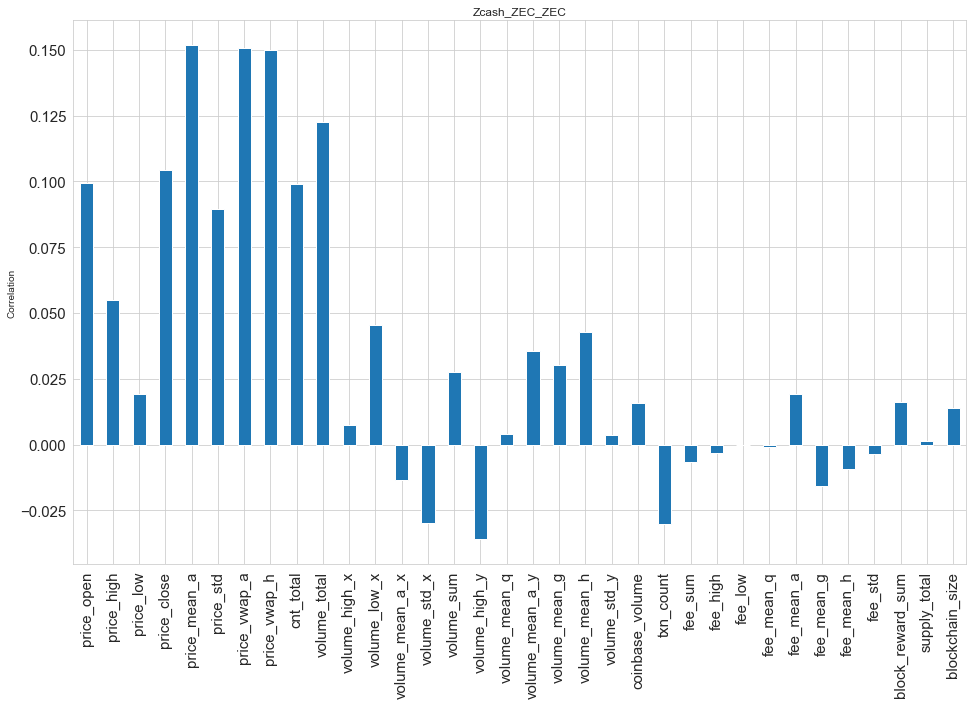

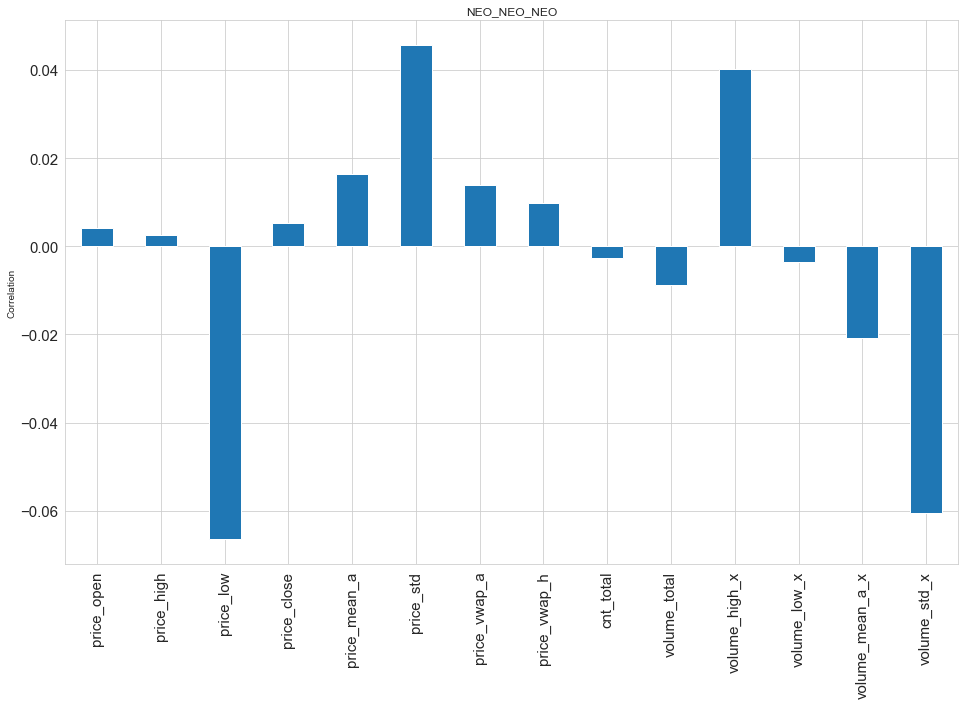

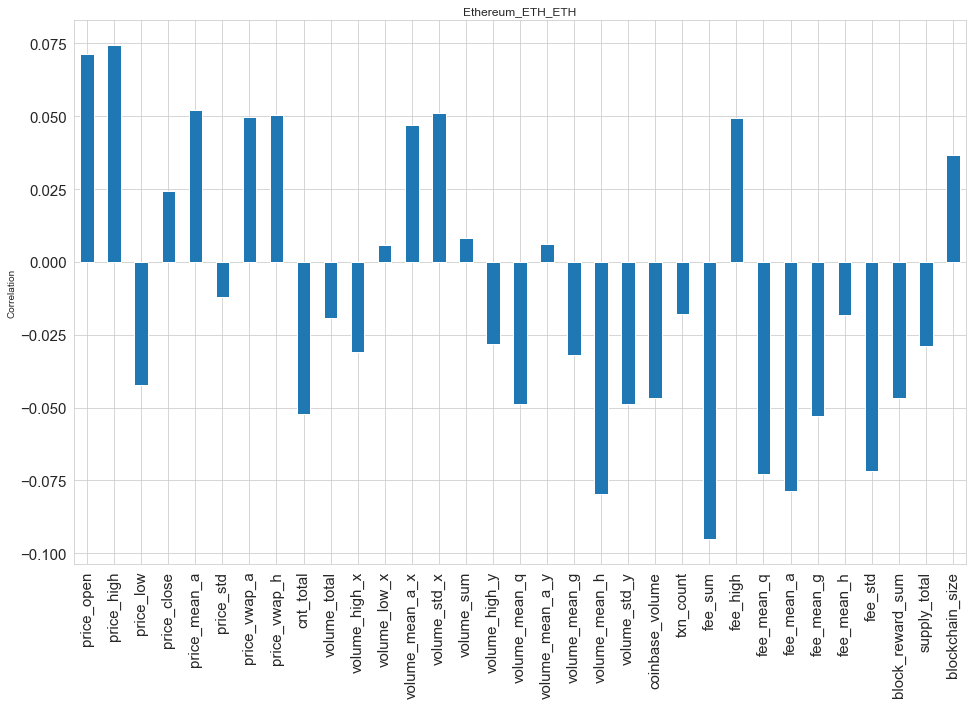

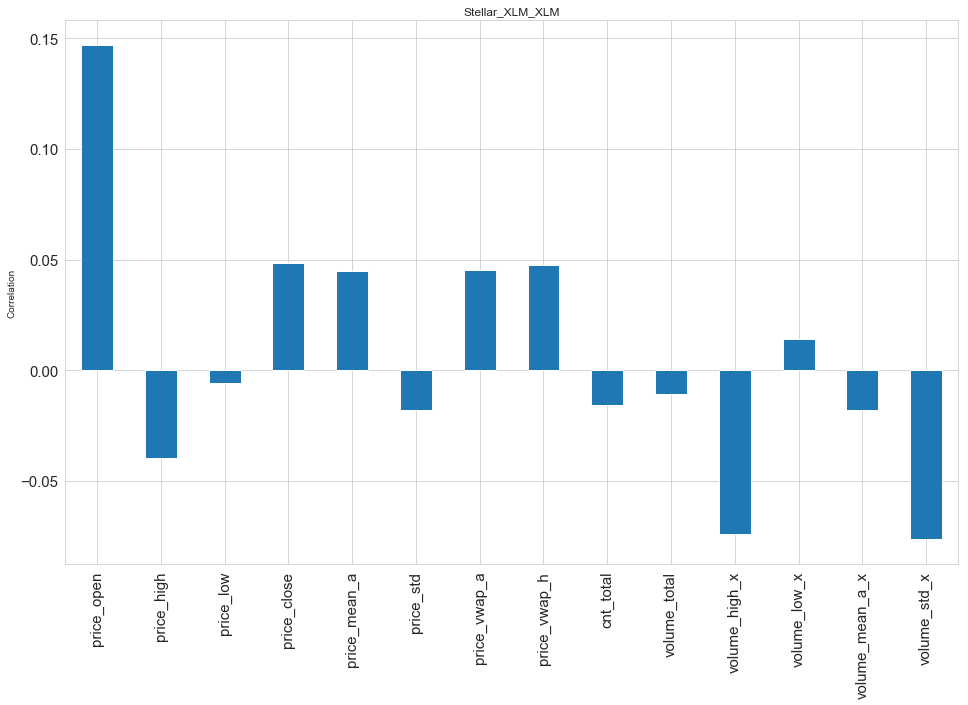

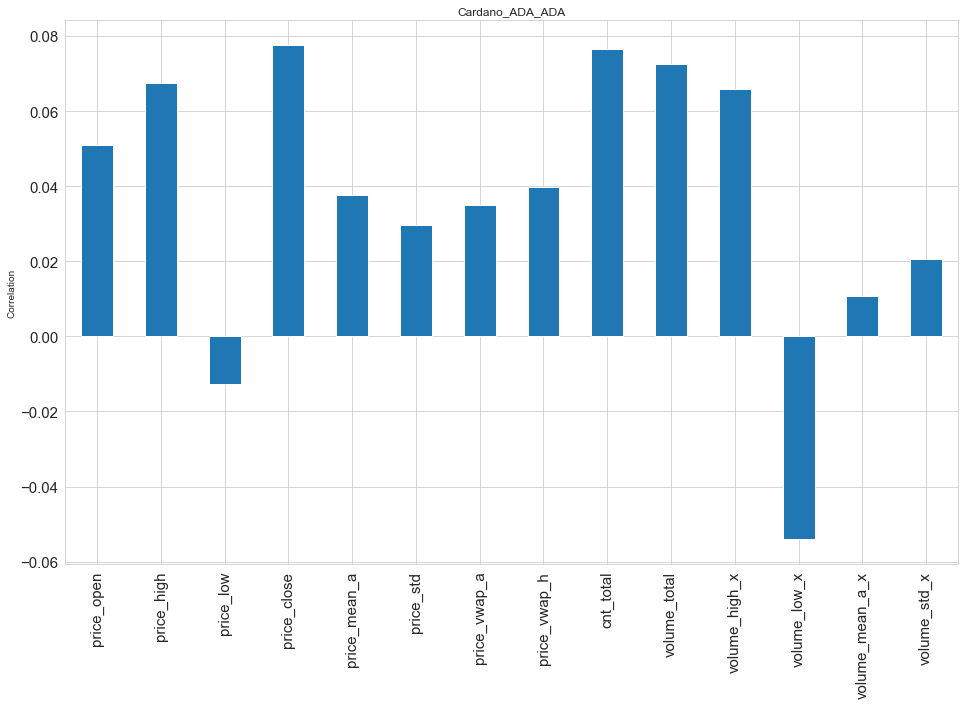

In [12]:
# Correlation with Response
sns.set_style('whitegrid')
for i in set(new_data['asset_id']):
    mask = np.where(new_data['asset_id']==i)
    new_data.iloc[mask].drop('return_1d',axis=1).dropna(how='all',axis=1).corrwith(new_data.iloc[mask[0],-1]).plot.bar(
    figsize=(16,10),
    title = 'Correlation with Response Variable',
    fontsize = 15, rot = 90,
    grid = True)
    plt.title(i)
    #plt.xticks(rotation=45)
    plt.ylabel('Correlation')
    plt.show()

The chart below shows the probability distribution of one day returns. The higher the line, the more times that one day return has occurred. The highest chances are centered around zero. The blue line shows your chances if you are in the market everyday. The orange line shows the probabilities if you only invest when the supply of Bitcoins mined today was in it's lowest 15%. This information is useful because you can see the probability of a large one day loss increase immensely when Bitcoin supply is growing slower than usual. Digital Asset Data has blockchain data that can aid in managing risk and creating trading strategies.

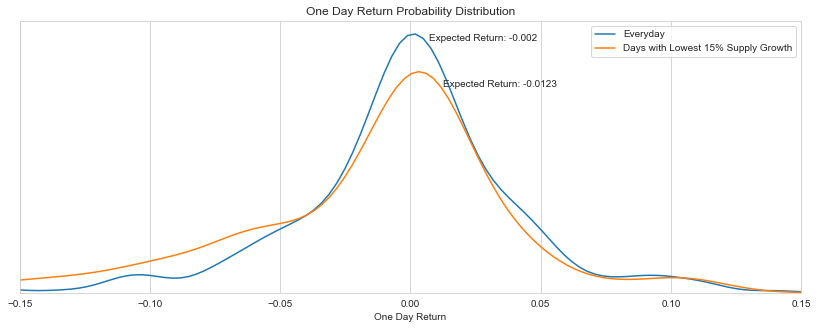

In [9]:
# Take Bitcoin subset
bitcoin = new_data[new_data['asset_id'] == 'Bitcoin_BTC_BTC']

# Calculate supply change threshold
thres = bitcoin['supply_total'].quantile(.15)

# Calculate expected 1 day return for the period and for the subset
avg = round(bitcoin['return_1d'].mean(),4)
sel_avg = round(bitcoin[bitcoin['supply_total']<thres]['return_1d'].mean(),4)

# Kernel density plots for probability distribution
plt.figure(figsize=(14,5))
sns.kdeplot(bitcoin['return_1d'].dropna(), label='Everyday')
sns.kdeplot(bitcoin[bitcoin['supply_total']<thres]['return_1d'],label='Days with Lowest 15% Supply Growth')
plt.text(.007,13.5,'Expected Return: ' + str(avg))
plt.text(.0125,11,'Expected Return: ' + str(sel_avg))
plt.xlim(-.15,.15)
plt.xlabel('One Day Return')
plt.yticks([])
plt.title('One Day Return Probability Distribution')
plt.show()